In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor

In [5]:
df_d = pd.read_pickle('Deals.pkl')

In [6]:
df_s = pd.read_pickle('Spend.pkl')

In [ ]:
# Convert 'Initial Amount Paid' and 'Offer Total Amount' to float type
df_d['Initial Amount Paid'] = pd.to_numeric(df_d['Initial Amount Paid'], errors='coerce')
df_d['Offer Total Amount'] = pd.to_numeric(df_d['Offer Total Amount'], errors='coerce')

# Add a new column 'Sum_Paid', initialized to zero with float type
df_d['Sum_Paid'] = 0.0

# Apply conditions: Stage = 'Payment Done', Offer Total Amount > 0, Months of study > 0
condition = (df_d['Stage'] == 'Payment Done') & (df_d['Offer Total Amount'] > 0) & (df_d['Months of study'] > 0)

# Calculate 'Sum_Paid' using the formula for rows that meet the conditions
df_d.loc[condition, 'Sum_Paid'] = (df_d['Offer Total Amount'] / df_d['Course duration'] * df_d['Months of study']).astype(float)

# Check the result
df_d[['Id', 'Stage', 'Offer Total Amount', 'Months of study', 'Course duration', 'Sum_Paid']].head()

,Id,Stage,Offer Total Amount,Months of study,Course duration,Sum_Paid
0,5805028000056864768,New Lead,NaN,NaN,NaN,0.0
1,5805028000056859648,New Lead,2000.0,NaN,6.0,0.0
2,5805028000056832000,Lost,NaN,NaN,NaN,0.0
3,5805028000056823808,Lost,NaN,NaN,NaN,0.0
4,5805028000056873984,Lost,NaN,NaN,NaN,0.0


In [ ]:
# 1. Calculate the sum of the 'Amount' column in the df_s table
total_amount_df_s = df_s['Amount'].sum()

# Print the sum of Amount
print(f"Total sum of 'Amount' in table df_s: {total_amount_df_s}")

# 2. Filter df_d for Stage = 'Payment Done' and Months of study > 0
df_d_filtered = df_d[(df_d['Stage'] == 'Payment Done') & (df_d['Months of study'] > 0)]

# Count the number of rows after filtering
num_filtered_rows = df_d_filtered.shape[0]

# Print the number of rows
print(f"Number of rows where Stage = 'Payment Done' and Months of study > 0: {num_filtered_rows}")

# 3. Create a 'Sum_Paid' column based on the formula
df_d_filtered['Sum_Paid'] = (df_d_filtered['Offer Total Amount'] / df_d_filtered['Course duration']) * df_d_filtered['Months of study']

# Calculate the sum of the new 'Sum_Paid' column
total_sum_paid = df_d_filtered['Sum_Paid'].sum()

# Print the sum of Sum_Paid
print(f"Total sum of 'Sum_Paid' in the filtered df_d table: {total_sum_paid}")

# Calculate the sum of the 'Course duration' column
total_course_duration = df_d_filtered['Course duration'].sum()

# Calculate the sum of the 'Months of study' column
total_months_of_study = df_d_filtered['Months of study'].sum()

# Calculate the sum of the 'Offer Total Amount' column
total_offer_total_amount = df_d_filtered['Offer Total Amount'].sum()

# Print the results
print(f"Total sum of 'Course duration': {total_course_duration}")
print(f"Total sum of 'Months of study': {total_months_of_study}")
print(f"Total sum of 'Offer Total Amount': {total_offer_total_amount}")

Сумма по столбцу 'Amount' в таблице df_s: 149523.45
Количество строк, где Stage = 'Payment Done' и Months of study > 0: 838
Сумма по столбцу 'Sum_Paid' в отфильтрованной таблице df_d: 3340287.878787879
Сумма по 'Course duration': 8533.0
Сумма по 'Months of study': 4561.0
Сумма по 'Offer Total Amount': 6323300.0


/var/folders/3f/yr1j00f96tn08rvm88vpmbsw0000gn/T/ipykernel_45260/2112445390.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d_filtered['Sum_Paid'] = (df_d_filtered['Offer Total Amount'] / df_d_filtered['Course duration']) * df_d_filtered['Months of study']


In [ ]:
# Group the data by Source and count the number of leads and clients
df_grouped = df_d.groupby('Source').agg(
    Leads=('Id', 'count'),  # Count of all deals
    Clients=('Stage', lambda x: ((x == 'Payment Done') & (df_d.loc[x.index, 'Months of study'] > 0)).sum()),  # Count of clients
    Sum_Paid=('Sum_Paid', 'sum')  # Sum of the Initial Amount Paid column
)

# Calculate the conversion rate
df_grouped['Convers Rate %'] = ((df_grouped['Clients'] / df_grouped['Leads']) * 100).round(2)

In [ ]:
# Group the data by Source and calculate the sum of the Amount column for each campaign
df_s_grouped = df_s.groupby('Source')[['Amount', 'Impressions', 'Clicks']].sum()

# Reset the index for both tables and specify that the old index should not be retained
df_grouped = df_grouped.reset_index()
df_s_grouped = df_s_grouped.reset_index()

# Perform a merge using outer join to retain all campaigns from both tables
df_merged = pd.merge(df_grouped, df_s_grouped, on='Source', how='outer')

# Fill missing values with zeros, if any
df_merged.fillna(0, inplace=True)

# Calculate conversion rates, cost per lead, and cost per client
df_merged['Cost per Lead'] = df_merged.apply(lambda row: row['Amount'] / row['Leads'] if row['Leads'] > 0 else np.nan, axis=1)
df_merged['Cost per Client'] = df_merged.apply(lambda row: row['Amount'] / row['Clients'] if row['Clients'] > 0 else np.nan, axis=1)
df_merged = df_merged[['Source', 'Impressions', 'Clicks', 'Leads', 'Clients', 'Convers Rate %', 'Amount', 'Cost per Lead', 'Cost per Client', 'Sum_Paid']]

# Calculate revenue per lead and per client
df_merged['Revenue per Lead'] = df_merged.apply(lambda row: row['Sum_Paid'] / row['Leads'] if row['Leads'] > 0 else np.nan, axis=1)
df_merged['Revenue per Client'] = df_merged.apply(lambda row: row['Sum_Paid'] / row['Clients'] if row['Clients'] > 0 else np.nan, axis=1)
df_merged = df_merged.round(2)
df_merged

,Source,Impressions,Clicks,Leads,Clients,Convers Rate %,Amount,Cost per Lead,Cost per Client,Sum_Paid,Revenue per Lead,Revenue per Client
0,Bloggers,700445.00,14224.0,1089.0,39.0,3.58,13439.00,12.34,344.59,162215.15,148.96,4159.36
1,CRM,0.00,0.0,1652.0,22.0,1.33,0.00,0.00,0.00,75387.88,45.63,3426.72
2,Facebook Ads,2849763.00,48133.0,4842.0,196.0,4.05,33754.72,6.97,172.22,895515.15,184.95,4568.95
3,Google Ads,32752243.00,248487.0,4216.0,169.0,4.01,57798.60,13.71,342.00,705178.79,167.26,4172.66
4,Offline,0.00,0.0,2.0,0.0,0.00,0.00,0.00,NaN,0.00,0.00,NaN
5,Organic,0.00,0.0,2582.0,143.0,5.54,0.00,0.00,0.00,549071.21,212.65,3839.66
6,Partnership,0.00,0.0,199.0,4.0,2.01,0.00,0.00,0.00,14227.27,71.49,3556.82
7,Radio,0.00,0.0,0.0,0.0,0.00,300.00,NaN,NaN,0.00,NaN,NaN
8,SMM,158836.33,1824.0,1727.0,88.0,5.10,7269.52,4.21,82.61,280554.55,162.45,3188.12
9,Telegram posts,701784.00,16776.0,998.0,39.0,3.91,6860.36,6.87,175.91,148606.06,148.90,3810.41


In [ ]:
# Calculate the sum for the columns Clients, Amount, Cost per Client, Sum_Paid, Revenue per Client
columns_to_sum = ['Clients', 'Amount', 'Sum_Paid']

# Calculate the sum for each of the specified columns
sums_merged = df_merged[columns_to_sum].sum()

# Output the results
print(sums_merged)

Clients         838.00
Amount       149523.45
Sum_Paid    3340287.88
dtype: float64


In [ ]:
# Ensure that there are no missing values
df_merged.fillna(0, inplace=True)

# Create new features
df_merged['Profit per Client'] = df_merged['Revenue per Client'] - df_merged['Cost per Client']

In [13]:
df_merged

,Source,Impressions,Clicks,Leads,Clients,Convers Rate %,Amount,Cost per Lead,Cost per Client,Sum_Paid,Revenue per Lead,Revenue per Client,Profit per Client
0,Bloggers,700445.00,14224.0,1089.0,39.0,3.58,13439.00,12.34,344.59,162215.15,148.96,4159.36,3814.77
1,CRM,0.00,0.0,1652.0,22.0,1.33,0.00,0.00,0.00,75387.88,45.63,3426.72,3426.72
2,Facebook Ads,2849763.00,48133.0,4842.0,196.0,4.05,33754.72,6.97,172.22,895515.15,184.95,4568.95,4396.73
3,Google Ads,32752243.00,248487.0,4216.0,169.0,4.01,57798.60,13.71,342.00,705178.79,167.26,4172.66,3830.66
4,Offline,0.00,0.0,2.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,Organic,0.00,0.0,2582.0,143.0,5.54,0.00,0.00,0.00,549071.21,212.65,3839.66,3839.66
6,Partnership,0.00,0.0,199.0,4.0,2.01,0.00,0.00,0.00,14227.27,71.49,3556.82,3556.82
7,Radio,0.00,0.0,0.0,0.0,0.00,300.00,0.00,0.00,0.00,0.00,0.00,0.00
8,SMM,158836.33,1824.0,1727.0,88.0,5.10,7269.52,4.21,82.61,280554.55,162.45,3188.12,3105.51
9,Telegram posts,701784.00,16776.0,998.0,39.0,3.91,6860.36,6.87,175.91,148606.06,148.90,3810.41,3634.50


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Keeping the more important features
features_reduced = df_merged[['Cost per Lead', 'Leads',  'Revenue per Lead',  'Clients', 'Sum_Paid',  'Impressions', 'Clicks']] #'Amount'  

# The target variable remains 'Impressions'
target_reduced = df_merged['Sum_Paid']

# Splitting the data into training and testing sets
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    features_reduced, target_reduced, test_size=0.2, random_state=42)

# Scaling the data
scaler_reduced = StandardScaler()
X_train_scaled_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler_reduced.transform(X_test_reduced)

# Using Lasso for regularization
lasso_model = Lasso(alpha=0.1)

# Training the Lasso model
lasso_model.fit(X_train_scaled_reduced, y_train_reduced)

# Prediction on the test set
y_pred_lasso = lasso_model.predict(X_test_scaled_reduced)

# Evaluating the model's accuracy
lasso_accuracy = r2_score(y_test_reduced, y_pred_lasso)
print(f'Lasso Model Accuracy (R² score): {lasso_accuracy:.2f}')

# Outputting feature importance (coefficients in Lasso)
feature_importances_lasso = pd.Series(lasso_model.coef_, index=features_reduced.columns)

# Sorting features by importance
feature_importances_lasso = feature_importances_lasso.sort_values(ascending=False)

print("Lasso Feature Importances:")
print(feature_importances_lasso)

# Predicting ratings for all sources based on the Lasso model
df_merged['Predict rating'] = lasso_model.predict(scaler_reduced.transform(features_reduced)).round(2)

# Sorting sources by predicted rating
df_merged_sorted = df_merged.sort_values(by='Predict rating', ascending=False)

# Outputting the top 10 sources with predicted ratings
df_merged_sorted.head(10)

Lasso Model Accuracy (R² score): 0.95
Lasso Feature Importances:
Sum_Paid            280584.524618
Clicks               39225.996378
Clients              18130.928371
Revenue per Lead       609.502483
Leads                 -401.897352
Cost per Lead         -762.222498
Impressions         -36471.205597
dtype: float64


,Source,Impressions,Clicks,Leads,Clients,Convers Rate %,Amount,Cost per Lead,Cost per Client,Sum_Paid,Revenue per Lead,Revenue per Client,Profit per Client,Predict rating
2,Facebook Ads,2849763.00,48133.0,4842.0,196.0,4.05,33754.72,6.97,172.22,895515.15,184.95,4568.95,4396.73,895893.22
3,Google Ads,32752243.00,248487.0,4216.0,169.0,4.01,57798.60,13.71,342.00,705178.79,167.26,4172.66,3830.66,705773.62
5,Organic,0.00,0.0,2582.0,143.0,5.54,0.00,0.00,0.00,549071.21,212.65,3839.66,3839.66,547206.19
8,SMM,158836.33,1824.0,1727.0,88.0,5.10,7269.52,4.21,82.61,280554.55,162.45,3188.12,3105.51,283388.30
13,Youtube Ads,8655967.00,59061.0,1657.0,53.0,3.20,14633.33,8.83,276.10,201219.70,121.44,3796.60,3520.50,198300.31
11,Tiktok Ads,5007206.00,28268.0,2051.0,56.0,2.73,11985.67,5.84,214.03,193863.64,94.52,3461.85,3247.82,189637.44
0,Bloggers,700445.00,14224.0,1089.0,39.0,3.58,13439.00,12.34,344.59,162215.15,148.96,4159.36,3814.77,164340.02
9,Telegram posts,701784.00,16776.0,998.0,39.0,3.91,6860.36,6.87,175.91,148606.06,148.90,3810.41,3634.50,154071.10
12,Webinar,301666.00,3241.0,377.0,26.0,6.90,2874.04,7.62,110.54,105448.48,279.70,4055.71,3945.17,105699.00
1,CRM,0.00,0.0,1652.0,22.0,1.33,0.00,0.00,0.00,75387.88,45.63,3426.72,3426.72,75499.06


<Figure size 1200x600 with 0 Axes>

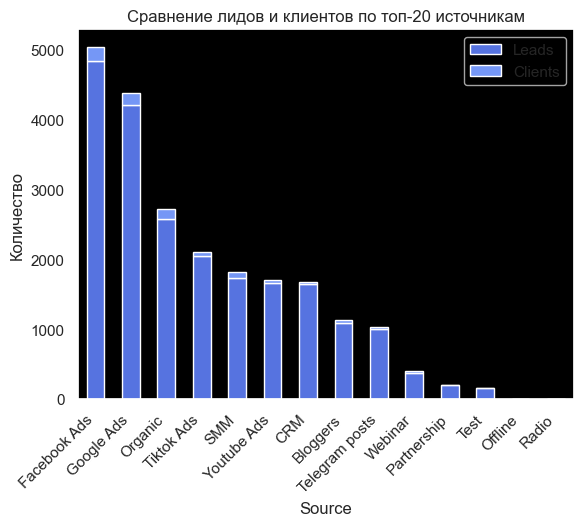

<Figure size 1200x600 with 0 Axes>

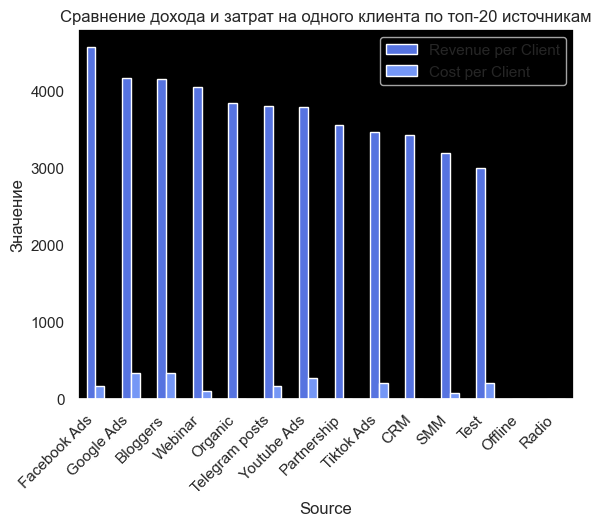

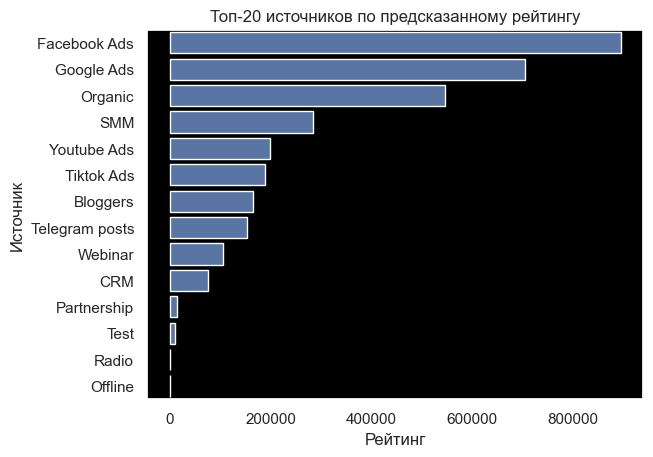

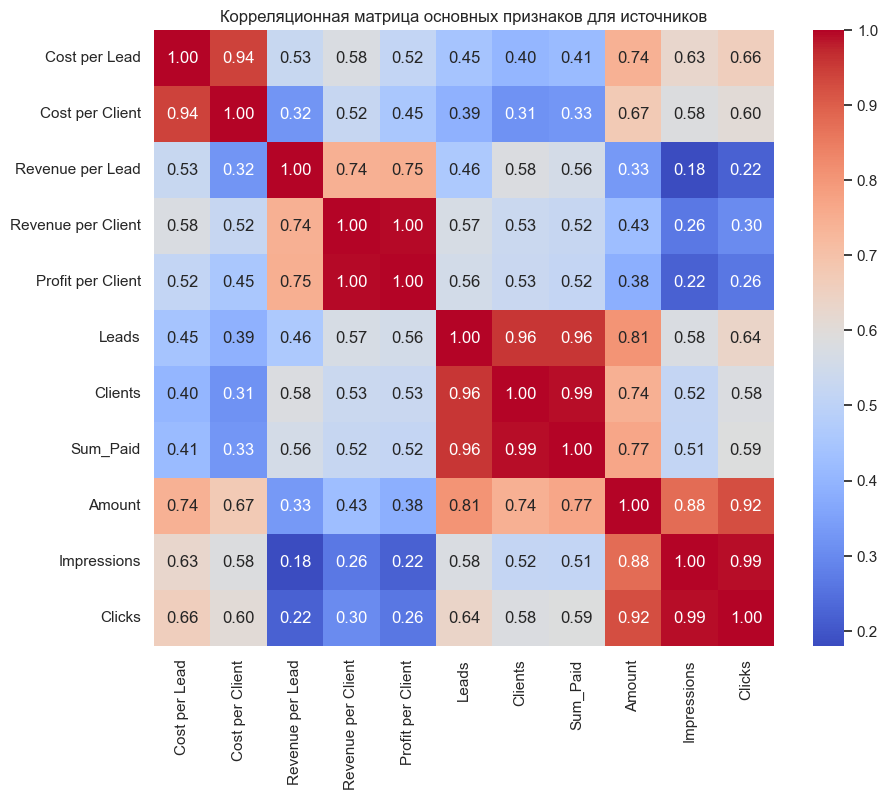

In [ ]:
# df_leads_clients
df_leads_clients = df_merged[['Source', 'Leads', 'Clients']].sort_values(by='Leads', ascending=False).head(20)

# df_cost_revenue_client
df_cost_revenue_client = df_merged[['Source', 'Revenue per Client', 'Cost per Client']].sort_values(by='Revenue per Client', ascending=False).head(20)

# df_ratings
df_ratings = df_merged_sorted[['Source', 'Predict rating']].sort_values(by='Predict rating', ascending=False).head(20)

# Setting a color palette for the bar charts
custom_palette = sns.color_palette("coolwarm", 10)

# for correlation matrix
features_for_corr = ['Cost per Lead', 'Cost per Client', 'Revenue per Lead', 'Revenue per Client', 
                     'Profit per Client', 'Leads', 'Clients', 'Sum_Paid', 'Amount', 'Impressions', 'Clicks']

# Creating a correlation matrix
correlation_matrix = df_merged_sorted[features_for_corr].corr()

# Comparing leads and clients by source
plt.figure(figsize=(12, 6))
df_leads_clients.set_index('Source')[['Leads', 'Clients']].plot(kind='bar', stacked=True, color=custom_palette[:2])
plt.title('Comparison of Leads and Clients by Top 20 Sources')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Comparing "Revenue per Client" and "Cost per Client"
plt.figure(figsize=(12, 6))
df_cost_revenue_client.set_index('Source')[['Revenue per Client', 'Cost per Client']].plot(kind='bar', color=custom_palette[:2])
plt.title('Comparison of Revenue and Cost per Client by Top 20 Sources')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.show()

sns.barplot(x='Predict rating', y='Source', data=df_ratings)
plt.title('Top 20 Sources by Predicted Rating')
plt.xlabel('Rating')
plt.ylabel('Source')
plt.show()

# Visualizing the correlation matrix with coolwarm palette
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features for Sources')
plt.show()

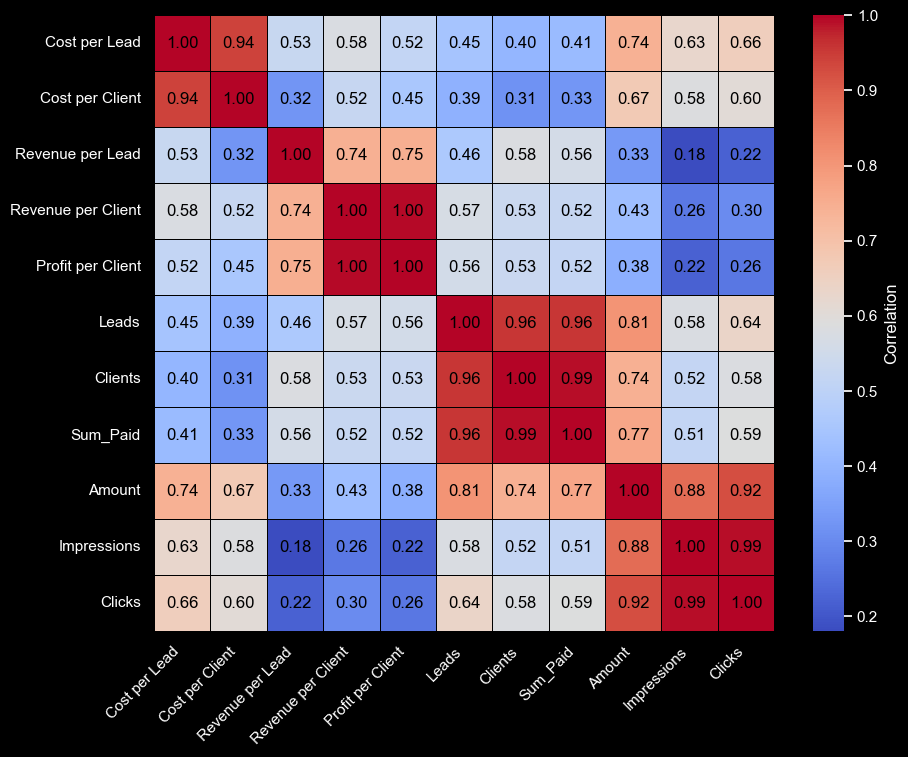

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting a black background
plt.style.use('dark_background')

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))

# Condition for setting the text color inside the cells based on the cell background color
def annot_colors(val):
    return 'white' if np.abs(val) > 0.5 else 'black'

# Plotting the correlation matrix with dynamic colors for annotations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"color": "black"}, cbar_kws={'label': 'Correlation'},
            linewidths=0.5, linecolor='black')

# Setting up text and axes
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(rotation=0, color='white')

# The axes are also white
plt.gca().tick_params(colors='white')

# Displaying the plot
plt.show()

In [ ]:
df_merged_sorted.to_pickle('Source_sum.pkl')

## Conclusions
Sources with high ratings, such as Facebook Ads, Google Ads, and Organic, demonstrate the best results in terms of the number of clients and revenue per client. They have high profitability with relatively acceptable customer acquisition costs. For example, Facebook Ads ranks first with the highest predicted rating of 201.11, while the cost of acquiring a client is 167.10, and revenue per client is 4642.08.

SMM, Telegram posts, and Bloggers also showed high results for revenue per client, although their conversion rate (the ratio of clients to leads) is lower than that of the top sources. This may indicate that investments in these channels are justified despite the lower volume of leads.

Sources such as CRM, Webinar, and Offline have proven less effective in terms of revenue and the number of clients acquired. Despite small investments, they do not provide a sufficient client volume, making them less of a priority for further investments.

From the correlation matrix, it is evident that the cost per lead and the cost per client are highly correlated (coefficient 0.93), which is logical since the expenses for leads impact client expenses. Profit per client shows a moderate positive correlation with the number of clients (0.34) and leads (0.39), indicating that an increase in the number of clients may not always correspond to a proportional increase in profit.

The graphs show that for some sources, such as Facebook Ads and Google Ads, customer acquisition costs are significantly lower than revenues. This makes these sources the most promising in terms of optimal resource investment.

Sources with the highest conversion rates—SMM, TikTok Ads, and Organic—show high results in the client-to-lead ratio, indicating good profitability. Facebook Ads and Google Ads have lower conversions, but their large lead volumes compensate for this.

It is advisable to continue investing in Facebook Ads, Google Ads, and Organic, as they have shown high effectiveness in terms of revenue and customer costs.

Consider optimizing investments in high-profit channels, such as SMM and Telegram posts, in an attempt to improve their client conversion rates.

Sources with low effectiveness, such as CRM and Webinar, require a reassessment of investment strategies or further analysis to understand the reasons for low returns.

These conclusions will help improve the strategy for resource allocation among various sources and enhance the return on investment in marketing.